# Behavioral Research: Does sugar and fat change the feeding behavior of animals?

This Jupyter notebook plots the **average** feeding activity of the restricted-access rats in (1) the first 3 hours of the 8-hour window and (2) the final 3 hours of the 8-hour window. 

## Import Libraries

In [1]:
#----------------------------------------------------------
# Import important libraries
#----------------------------------------------------------
import pandas as pd
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import matplotlib.gridspec as gridspec

#----------------------------------------------------------
# Set Fonts and Background for the Figures
#----------------------------------------------------------
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.edgecolor': 'black', 'font.family': 'Arial'})
plt.rcParams['figure.dpi'] = 1000

## Read in CSV Files with Binary Feeding Behavior

In [2]:
# Links to all CSV files
hfhs_adlib_feeding_location = "https://www.dropbox.com/s/hvz5lziuutmk45v/Feeding_HFHS_AdLib_Binary.csv?dl=1"
cont_adlib_feeding_location = "https://www.dropbox.com/s/4ref8epzejqccvv/Feeding_Control_AdLib_Binary.csv?dl=1"
hfhs_restr_feeding_location = "https://www.dropbox.com/s/n5tux2lq630x747/Feeding_HFHS_Restricted_Binary.csv?dl=1"
cont_restr_feeding_location = "https://www.dropbox.com/s/2ihaa7zfh8uwi1s/Feeding_Control_Restricted_Binary.csv?dl=1"

# Feeding
hfhs_adlib_feeding = pd.read_csv(hfhs_adlib_feeding_location, index_col='Date_Time', parse_dates=True)
cont_adlib_feeding = pd.read_csv(cont_adlib_feeding_location, index_col='Date_Time', parse_dates=True)
hfhs_restr_feeding = pd.read_csv(hfhs_restr_feeding_location, index_col='Date_Time', parse_dates=True)
cont_restr_feeding = pd.read_csv(cont_restr_feeding_location, index_col='Date_Time', parse_dates=True)

hfhs_adlib_feeding.head()

,Rat21,Rat22,Rat23,Rat26,Rat27
Date_Time,,,,,
1970-01-01 21:00:00,0,0,0,0,0.0
1970-01-01 21:00:01,0,0,0,0,0.0
1970-01-01 21:00:02,0,0,0,0,0.0
1970-01-01 21:00:03,0,0,0,0,0.0
1970-01-01 21:00:04,0,0,0,0,0.0


In these CSV files, there is a datetime index that is separated in 1-second intervals. Each of the columns represents a different rat. The only possible column values are:
* **1** (which means that the rat is feeding in that 1-second interval)
* **0** (which means that the rat is *not* feeding in that 1-second interval)
* **NaN** (which means there was no video activity recorded for that rat during that 1-second interval)

## Download file with diet group information

In [3]:
#----------------------------------------------------------
# Import CSV with diet and feeding access for each rat
#----------------------------------------------------------
groups_location = 'https://www.dropbox.com/s/37toe3vct1pipn5/groups.csv?dl=1'
groups_data = pd.read_csv(groups_location , index_col=0)
groups_data.head() 

,diet,feeding
Rat,,
1,control,ad lib
2,control,ad lib
3,control,ad lib
4,control,ad lib
5,control,ad lib


## Download plot parameters

In [4]:
plot_data_location = "https://www.dropbox.com/s/djpbvky0mwxpups/plotting_by_group.csv?dl=1"
plot_parameters = pd.read_csv(plot_data_location, index_col=0)
plot_parameters

,color,marker,line_type,hatches,hatch_colors,fill_color,label
group,,,,,,,
control ad lib,grey,o,-,,grey,grey,CA
control restriction,grey,v,--,/,grey,white,CR
HFHS ad lib,red,o,-,,red,red,HA
HFHS restriction,red,v,--,/,red,white,HR


## Create New Dataframes that: 
1. **Resample the Binary Data by 1 Hour.**

This will calculate the **Hourly Feeding Activity** for every rat (number of seconds spent feeding in each hour). After calculating this Hourly Feeding Activity, I will only select the hours in the 8-hour restricted feeding window (from 23:00 to 7:00)

2. **Divide the Hourly Feeding Activity dataframes into 3 phases (First 2 hours, Mid 4 hours, and Last 2 hours)**

### 1. Resample the Binary Data by 1 Hour.

In [5]:
# Resample all of the dataframes by 1 Hour. I couldn't do just .resample ("1H") because that would 
# replace NaN values with 0's, which is artificially skewing the data
cont_adlib_feeding_hourly = cont_adlib_feeding.resample("1H",how=lambda x: x.values.sum()).T
hfhs_adlib_feeding_hourly = hfhs_adlib_feeding.resample("1H",how=lambda x: x.values.sum()).T
cont_restr_feeding_hourly = cont_restr_feeding.resample("1H",how=lambda x: x.values.sum()).T
hfhs_restr_feeding_hourly = hfhs_restr_feeding.resample("1H",how=lambda x: x.values.sum()).T

# Combine all 4 new dataframes into one list
hourly_feeding_frames = [cont_adlib_feeding_hourly, cont_restr_feeding_hourly, hfhs_adlib_feeding_hourly, hfhs_restr_feeding_hourly]

# Concatenate/Merge all 4 dataframes into 1 dataframe
feeding_hourly_frame = pd.concat(hourly_feeding_frames)

# Set the index of the new dataframe as just the rat numbers (i.e. "2" instead of "Rat2"). 
# This will set the index to the same index as the groups_data dataframe
feeding_hourly_frame.index = feeding_hourly_frame.index.map(lambda x: int(str(x)[3:]))

# Add a new column that holds the diet group information (which of the 4 diet groups that the rat belongs to)
feeding_hourly_frame['group']=groups_data.loc[feeding_hourly_frame.index].diet+' '+groups_data.loc[feeding_hourly_frame.index].feeding

# Rename all of the columns into actual hour times - making it easier to choose columns
feeding_hourly_frame.columns = ["21:00", "22:00", "23:00", "0:00", "1:00", "2:00", "3:00", "4:00",
                                "5:00", "6:00", "7:00", "8:00", "9:00", "10:00", "11:00", "12:00",
                                "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00",
                                "group"]

# Select only the final 3 hours of interest (from 4:00 to 7:00)
final_hours_of_interest = feeding_hourly_frame[["4:00", "5:00", "6:00", "group"]]
final_hours_of_interest = final_hours_of_interest[(final_hours_of_interest["group"] == "control restriction") | (final_hours_of_interest["group"] == "HFHS restriction")]

# Select only the first 3 hours of interest (from 23:00 to 2:00)
first_hours_of_interest = feeding_hourly_frame[["23:00", "0:00", "1:00", "group"]]
first_hours_of_interest = first_hours_of_interest[(first_hours_of_interest["group"] == "control restriction") | (first_hours_of_interest["group"] == "HFHS restriction")]

# Preview
first_hours_of_interest

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


,23:00,0:00,1:00,group
10,345.0,1075.0,0.0,control restriction
11,72.0,101.0,0.0,control restriction
12,895.0,179.0,71.0,control restriction
13,1808.0,249.0,10.0,control restriction
14,NaN,1021.0,59.0,control restriction
15,135.0,238.0,235.0,control restriction
16,686.0,445.0,79.0,control restriction
17,1547.0,1664.0,1489.0,control restriction
18,NaN,25.0,43.0,control restriction
29,488.0,427.0,144.0,HFHS restriction


Here is a dataframe showing the feeding activity of each rat from 23:00 to 1:00. The index represents each rat number. The *group* column represents what diet group the rat was in. The column values represent the number of seconds that the rat spent feeding for that hour. 

For example, in the first cell (upper left cell), it contains the value 345.0. That means that Rat10 (row index)  spent 345 seconds feeding during the time interval from 23:00 to 23:59:59 (column header). Rat10 was also in the *control restriction* diet group.

### 2. Divide the Hourly Feeding Activity dataframes into 3 phases (First 2 hours, Mid 4 hours, and Last 2 hours)

I will create 3 dataframes - one for each phase, then I will merge these dataframes into one. The final dataframe will be used for plotting. 

I am making 3 dataframes because the data needs to be prepared a certain way for plotting:

* 1 column with diet group classification
* 1 column with phase type classification
* 1 column with the hourly feeding values (or hourly consumption rate)

Here is a preview of what it should look like for plotting:

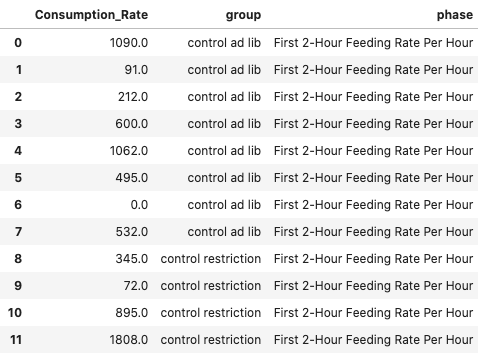

In [6]:
#----------------------------------------------------------
# 6th Hour Dataframe
#----------------------------------------------------------
# Create an empty dataframe
final_first_phase = pd.DataFrame()

# Combine/Merge the hourly feeding values from the first 2 hours into a single column
final_first_phase["Consumption_Rate"] = pd.concat([final_hours_of_interest["4:00"]])

# Add the "group" column into this dataframe
final_first_phase["group"] = final_hours_of_interest["group"]

# Create a new column with just the label "1st Phase" for all of the column values
final_first_phase["phase"] = "6th Hour"

# Make an arbitary index
final_first_phase = final_first_phase.reset_index(drop = True)

# Follow the same procedure for the other 2 phases.
# The only difference is the hours chosen for the "Consumption_Rate" column
#----------------------------------------------------------
# 7th Hour Dataframe
#----------------------------------------------------------
final_mid_phase = pd.DataFrame()
final_mid_phase["Consumption_Rate"] = pd.concat([final_hours_of_interest["5:00"]])
final_mid_phase["group"] = final_hours_of_interest["group"]
final_mid_phase["phase"] = "7th Hour"
final_mid_phase = final_mid_phase.reset_index(drop = True)

#----------------------------------------------------------
# 8th Hour Dataframe
#----------------------------------------------------------
final_last_phase = pd.DataFrame()
final_last_phase["Consumption_Rate"] = pd.concat([final_hours_of_interest["6:00"]])
final_last_phase["group"] = final_hours_of_interest["group"]
final_last_phase["phase"] = "8th Hour"
final_last_phase = final_last_phase.reset_index(drop = True)

# Perform the same process for the first 3 hours as well
#----------------------------------------------------------
# 1st Hour Dataframe
#----------------------------------------------------------
# Create an empty dataframe
first_first_phase = pd.DataFrame()

# Combine/Merge the hourly feeding values from the first 2 hours into a single column
first_first_phase["Consumption_Rate"] = pd.concat([first_hours_of_interest["23:00"]])

# Add the "group" column into this dataframe
first_first_phase["group"] = first_hours_of_interest["group"]

# Create a new column with just the label "1st Phase" for all of the column values
first_first_phase["phase"] = "1st Hour"

# Make an arbitary index
first_first_phase = first_first_phase.reset_index(drop = True)

# Follow the same procedure for the other 2 phases.
# The only difference is the hours chosen for the "Consumption_Rate" column
#----------------------------------------------------------
# Middle Phase Dataframe
#----------------------------------------------------------
first_mid_phase = pd.DataFrame()
first_mid_phase["Consumption_Rate"] = pd.concat([first_hours_of_interest["0:00"]])
first_mid_phase["group"] = first_hours_of_interest["group"]
first_mid_phase["phase"] = "2nd Hour"
first_mid_phase = first_mid_phase.reset_index(drop = True)

#----------------------------------------------------------
# Last Phase Dataframe
#----------------------------------------------------------
first_last_phase = pd.DataFrame()
first_last_phase["Consumption_Rate"] = pd.concat([first_hours_of_interest["1:00"]])
first_last_phase["group"] = first_hours_of_interest["group"]
first_last_phase["phase"] = "3rd Hour"
first_last_phase = first_last_phase.reset_index(drop = True)

# Preview
first_last_phase.head(10)

,Consumption_Rate,group,phase
0,0.0,control restriction,3rd Hour
1,0.0,control restriction,3rd Hour
2,71.0,control restriction,3rd Hour
3,10.0,control restriction,3rd Hour
4,59.0,control restriction,3rd Hour
5,235.0,control restriction,3rd Hour
6,79.0,control restriction,3rd Hour
7,1489.0,control restriction,3rd Hour
8,43.0,control restriction,3rd Hour
9,144.0,HFHS restriction,3rd Hour


### Create a single dataframe for plotting

In [7]:
#----------------------------------------------------------
# 1-Way ANOVA Dataframe
#----------------------------------------------------------
# Combine all of the 3 previous dataframes into 1
final_phase_frame = pd.concat([final_first_phase, final_mid_phase, final_last_phase])
final_phase_frame = final_phase_frame.dropna()

#----------------------------------------------------------
# 1-Way ANOVA Dataframe
#----------------------------------------------------------
# Combine all of the 3 previous dataframes into 1
first_phase_frame = pd.concat([first_first_phase, first_mid_phase, first_last_phase])
first_phase_frame = first_phase_frame.dropna()
first_phase_frame.head(10)

,Consumption_Rate,group,phase
0,345.0,control restriction,1st Hour
1,72.0,control restriction,1st Hour
2,895.0,control restriction,1st Hour
3,1808.0,control restriction,1st Hour
5,135.0,control restriction,1st Hour
6,686.0,control restriction,1st Hour
7,1547.0,control restriction,1st Hour
9,488.0,HFHS restriction,1st Hour
10,103.0,HFHS restriction,1st Hour
11,176.0,HFHS restriction,1st Hour


## Reorder the dataframe according to diet group:
1. Cont Res
2. HFHS Res

This will make the diet groups appear in this order for the barplot

In [8]:
#Create a new column that orders the values in the order given
final_phase_frame["barplot_order"] = pd.Categorical(final_phase_frame.group, categories=["control restriction","HFHS restriction"], ordered=True)

# Reorder the dataframe based on custom order
final_barplot_frame = final_phase_frame.sort_values(["barplot_order", "phase"]).reset_index(drop = True)

#Create a new column that orders the values in the order given
first_phase_frame["barplot_order"] = pd.Categorical(first_phase_frame.group, categories=["control restriction","HFHS restriction"], ordered=True)

# Reorder the dataframe based on custom order
first_barplot_frame = first_phase_frame.sort_values(["barplot_order", "phase"]).reset_index(drop = True)
first_barplot_frame.head(10)

,Consumption_Rate,group,phase,barplot_order
0,345.0,control restriction,1st Hour,control restriction
1,72.0,control restriction,1st Hour,control restriction
2,895.0,control restriction,1st Hour,control restriction
3,1808.0,control restriction,1st Hour,control restriction
4,135.0,control restriction,1st Hour,control restriction
5,686.0,control restriction,1st Hour,control restriction
6,1547.0,control restriction,1st Hour,control restriction
7,1075.0,control restriction,2nd Hour,control restriction
8,101.0,control restriction,2nd Hour,control restriction
9,179.0,control restriction,2nd Hour,control restriction


## Add a new plot parameter "edgecolor" that defines the color of the edges for the bars

In [9]:
# Create a custom plot parameter for the barplot figure
barplot_plot_parameters = plot_parameters.reindex(["control ad lib", "HFHS ad lib", "control restriction", "HFHS restriction"]).iloc[-2:]

# Add custom edge colors
barplot_plot_parameters["edgecolors"] = ["grey", "red"]
barplot_plot_parameters

,color,marker,line_type,hatches,hatch_colors,fill_color,label,edgecolors
group,,,,,,,,
control restriction,grey,v,--,/,grey,white,CR,grey
HFHS restriction,red,v,--,/,red,white,HR,red


## Function that creates bar plots

In [10]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [23]:
def bar_plot_graph(df, title, ymax = 600):
    ax = sns.barplot(x="group", y="Consumption_Rate", data = df, hue = "phase", 
                     ci = 68, capsize=.1, errwidth=0.9)
    
    # Collect the color properties for the bars
    first_phase_bars = ax.patches[0:2]
    second_phase_bars = ax.patches[2:4]
    third_phase_bars = ax.patches[4:6]
    
    
    # Make hatched pattern to distinguish between Ad lib and restriction
    for i, hatch, fill, firstphase, secondphase, thirdphase,  in zip(barplot_plot_parameters.edgecolors, barplot_plot_parameters.hatches, barplot_plot_parameters.fill_color, first_phase_bars, second_phase_bars, third_phase_bars):
        # Set same face color for all 3 phases
        firstphase.set_facecolor(fill)
        secondphase.set_facecolor(fill)
        thirdphase.set_facecolor(fill)
        
        # Set same hatch color for all 3 phases
        firstphase.set_hatch(hatch)
        secondphase.set_hatch(hatch)
        thirdphase.set_hatch(hatch)
        
        # Set same edge color for all 3 phases - set new column in DropBox
        firstphase.set_edgecolor(i)
        secondphase.set_edgecolor(i)
        thirdphase.set_edgecolor(i)
        
        # Set "Hour" labels
        ax.text(firstphase.get_x() + firstphase.get_width() / 2, 0, "6th", ha = "center", va = "bottom", fontweight = 'bold', fontsize=9, color = "black")
        ax.text(secondphase.get_x() + secondphase.get_width() / 2, 0, "7th", ha = "center", va = "bottom", fontweight = 'bold', fontsize=9, color = "black")
        ax.text(thirdphase.get_x() + thirdphase.get_width() / 2, 0, "8th", ha = "center", va = "bottom", fontweight = 'bold', fontsize=9, color = "black")
        
        
    # Add x- and y-labels, ticks, and units
    plt.ylabel(title, fontsize=10, fontweight = "bold", color = "black")
    plt.ylim(0,ymax)
    plt.xlabel('')
    plt.xticks(range(len(barplot_plot_parameters.index)), ('Cont Res', 'HFHS Res'), fontweight = 'bold', fontsize=10, color = "black")
    plt.yticks(fontweight = 'bold', fontsize=10, color = "black")
    
    # Set error bar colors
    plt.setp(ax.lines[0:3] + ax.lines[6:9] + ax.lines[12:15] + ax.lines[18:21] + ax.lines[24:27] + ax.lines[30:33], color = "black")
    plt.setp(ax.lines[3:6] + ax.lines[9:12] + ax.lines[15:18] + ax.lines[21:24] + ax.lines[27:30] + ax.lines[33:36], color = "darkred")
    
    # Remove legend
    ax.get_legend().remove()
    
    # Remove unnecessary axes
    sns.despine()
    
    
    
    plt.tight_layout()
    
    

### Create Bar Graph

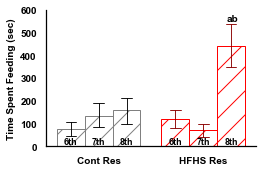

In [25]:
plt.figure(figsize=(3.75, 2.5))
# First 3 Hours
#plt.subplot(1, 2, 1)
#bar_plot_graph(first_barplot_frame,  "Time Spent Feeding (sec)")
# Add Label for Figure 1A
#plt.figtext(0.015, 0.93, "A", fontsize = 15, color = "black", fontweight = "bold")
#plt.figtext(0.2, 0.93, "First 3 Hours", fontsize = 15, color = "black", fontweight = "bold")

# Final 3 Hours
#plt.subplot(1, 2, 2)
bar_plot_graph(final_barplot_frame,  "Time Spent Feeding (sec)")
# Add Significance markers
plt.annotate('ab', (1.225, 550), fontsize=10, color = 'black', fontweight='bold')
# Add Label for Figure 1B
#plt.figtext(0.505, 0.93, "B", fontsize = 15, color = "black", fontweight = "bold")
#plt.figtext(0.7, 0.93, "Final 3 Hours", fontsize = 15, color = "black", fontweight = "bold")


#Save Figure in a TIFF file
plt.savefig("First & Final 3 Hours Feeding Time.tif", dpi = 1000)
plt.show()